# Import Librarys

In [ ]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Download nltk stopword, stemmer

In [ ]:
nltk.download('all')
nltk.download("stopwords")

# Load and Visualize data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fake.csv', usecols = ['title','text','language'])
#['uuid','author','title','text','language','site_url','country']
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,title,text,language
0,,I firmly believe for the population of which c...,english
1,Did Hillary Clinton Cheat at the Debate?,Daisy Luther \nI know the debate was a couple ...,english
2,"“We are losing control of the streets,” say po...",BNI Store Nov 2 2016 “We are losing control of...,english
3,RIGGED! DOJ Weiner Email Probe Will Be Led By ...,RIGGED! DOJ Weiner Email Probe Will Be Led By ...,english
4,NYPD Cop Who Killed Eric Garner to be Indicted...,NYPD Cop Who Killed Eric Garner to be Indicted...,english


# Preprocessing Function

In [ ]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')

def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()

def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

# Tokenize data

In [ ]:
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 3.3469874262809753 min


In [ ]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280

**Last 10 word in top K words**

In [ ]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('rosl', 1),
 ('steampow', 1),
 ('winatallcost', 1),
 ('tooledup', 1),
 ('rinder', 1),
 ('oskana', 1),
 ('snyderit', 1),
 ('percentso', 1),
 ('aroundjust', 1),
 ('republicansand', 1)]

In [ ]:
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('ziegler', 13),
 ('fortif', 13),
 ('benn', 13),
 ('grillsgt', 13),
 ('ernest', 13),
 ('lotion', 13),
 ('crisp', 13),
 ('imax', 13),
 ('leu', 13),
 ('freshman', 13)]

# preprocess to keep top K words

In [ ]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

# Tokenize data

In [ ]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

**Stats about data**

In [ ]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 345.66828518248764 
minimum document length 0 
maximum document length 11576


# Remove short article

In [ ]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 10812 articles


In [ ]:
df.head(3)

,uuid,author,title,text,language,site_url,country,tokenized
0,2dcfc3db5b8b74d98041d08ac8dae62944e37419,Joachim Hagopian,Another US False Flag?,"By Joachim Hagopian October 29, 2016 \nThe Wes...",english,lewrockwell.com,US,"[joachim, hagopian, octob, western, media, sei..."
1,6cec28c6ee03e73eab7e141dfd2da4191e5d4df0,Andrew Anglin,US and Allies Openly Massing Huge Army on Russ...,US and Allies Openly Massing Huge Army on Russ...,english,dailystormer.com,US,"[us, alli, openli, mass, huge, armi, russian, ..."
2,5fa56279455a0affbbf2475d4af5d04b359629cd,NaN,Beyond The Veil: Channeling My Sister’s Messag...,"By In5D on November 14, 2016 in Spiritual Awak...",english,in5d.com,US,"[ind, novemb, spiritu, awaken, first, time, ch..."


# Slpit dataset

In [ ]:
msk = np.random.rand(len(df)) < 0.80

train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

print(len(df),len(train_df),len(test_df))

10812 8671 2141


# LDA Trainer

In [ ]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 10
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

**Train LDA**

In [ ]:
dictionary,corpus,lda = train_lda(train_df)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Time to train LDA model on  10812 articles:  0.5253741621971131 min


**LDA Topic and top words**

In [ ]:
lda.show_topics(num_topics=10, num_words=20)

[(0,
  '0.037*"clinton" + 0.020*"hillari" + 0.019*"email" + 0.013*"fbi" + 0.011*"investig" + 0.009*"campaign" + 0.006*"comey" + 0.006*"would" + 0.006*"report" + 0.005*"inform" + 0.005*"state" + 0.005*"new" + 0.005*"elect" + 0.005*"said" + 0.005*"presid" + 0.005*"wikileak" + 0.005*"podesta" + 0.005*"obama" + 0.005*"news" + 0.004*"democrat"'),
 (1,
  '0.060*"trump" + 0.025*"elect" + 0.020*"vote" + 0.014*"donald" + 0.014*"hillari" + 0.013*"clinton" + 0.011*"democrat" + 0.010*"voter" + 0.009*"support" + 0.009*"presid" + 0.009*"american" + 0.009*"republican" + 0.008*"candid" + 0.008*"state" + 0.007*"parti" + 0.007*"media" + 0.007*"win" + 0.007*"campaign" + 0.007*"poll" + 0.007*"polit"'),
 (2,
  '0.010*"water" + 0.007*"said" + 0.007*"pipelin" + 0.007*"report" + 0.006*"protest" + 0.005*"land" + 0.005*"stand" + 0.005*"north" + 0.005*"dakota" + 0.005*"year" + 0.005*"camp" + 0.004*"rock" + 0.004*"area" + 0.004*"polic" + 0.004*"time" + 0.004*"energi" + 0.004*"access" + 0.004*"new" + 0.004*"also" 

**Topic and its top words**

In [ ]:
lda.show_topic(topicid=4, topn=5)

[('go', 0.012027981),
 ('like', 0.011535998),
 ('get', 0.011000965),
 ('peopl', 0.009750744),
 ('one', 0.009303042)]

In [ ]:
lda.show_topic(topicid=9, topn=5)

[('us', 0.01945395),
 ('russia', 0.016294932),
 ('war', 0.01573997),
 ('russian', 0.010540026),
 ('state', 0.010301189)]

# Result on sample train set example

In [ ]:
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

8656


In [ ]:
print(train_df.iloc[random_article_index,3])

November 2, 2016 Will Obama recognize Palestinian state? 
US President Barack Obama will be stepping down from eight years in office in January, but not before at least one more last ditch effort to save a foreign policy legacy marred by failure. 

According to Foundation for the Defense of Democracies Vice President Jonathan Schanzer, the White House try one more last ditch effort to solve the Israeli-Palestinian conflict, making moves ranging from sanctioning US citizens who do business with Israeli settlements all the way to possibly recognizing a Palestinian state. 

Speaking to the Wall Street Journal, Schanzer said that the Obama administration’s first course of action might be to adopt a UN Security Council Resolution condemning the settlements. 
Email (will not be published) (required) Website Sow a seed to help the Jewish people Follow Endtime Copyright © 2016 All Rights Reserved Endtime Ministries | End of the Age | Irvin Baxter Endtime Ministries, Inc. PO Box 940729 Plano, T

In [ ]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
print(np.array([tup[1] for tup in lda.get_document_topics(bow=bow)]))

[1.4502071e-01 4.3649066e-05 4.3649066e-05 4.3649066e-05 1.1009456e-01
 2.0927703e-01 3.9982563e-01 4.3649066e-05 4.3649066e-05 1.3556384e-01]


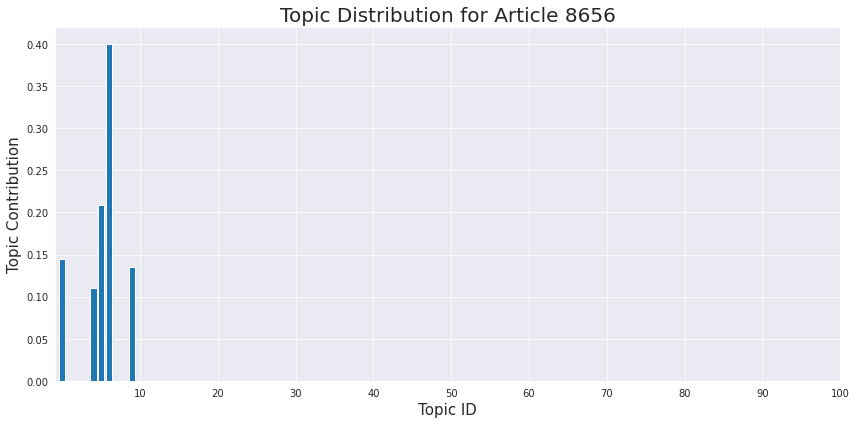

In [ ]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()


In [ ]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

4 [('go', 0.012027981), ('like', 0.011535998), ('get', 0.011000965), ('peopl', 0.009750744), ('one', 0.009303042), ('dont', 0.008453978), ('know', 0.008292153), ('say', 0.0076245745), ('want', 0.0072436254), ('make', 0.0072089266)] 

5 [('food', 0.013070557), ('use', 0.012166073), ('health', 0.009778163), ('also', 0.008461121), ('bodi', 0.0066153314), ('studi', 0.006266033), ('effect', 0.0062619415), ('medic', 0.006042993), ('jewish', 0.006000305), ('water', 0.0059274067)] 

2 [('water', 0.009610575), ('said', 0.007216422), ('pipelin', 0.007212644), ('report', 0.0066290176), ('protest', 0.005905348), ('land', 0.0054161637), ('stand', 0.0053167515), ('north', 0.004938546), ('dakota', 0.00493665), ('year', 0.0048171417)] 

7 [('syria', 0.01929458), ('us', 0.015079388), ('syrian', 0.014941897), ('forc', 0.013368824), ('saudi', 0.011263618), ('attack', 0.009866648), ('terrorist', 0.009632475), ('isi', 0.008531877), ('aleppo', 0.008333368), ('militari', 0.008047442)] 

0 [('clinton', 0.0374

# Predict topic on any sentence

In [ ]:
sentence  = "Joe Biden is US President "

**Topic prediction**

In [ ]:
print('sentence : ',sentence,'\n')
preprocess_sentence = stem_words(remove_stop_words(initial_clean(sentence)))
prediction = np.array([tup[1] for tup in lda.get_document_topics(bow=dictionary.doc2bow(preprocess_sentence))])
print('prediction : ',prediction,'\n')
print('predicted topic id :',np.argmax(prediction),'\n')
print('Top 10 words in predicted topic : ',lda.show_topic(topicid=np.argmax(prediction), topn=10))

sentence :  Joe Biden is US President  

prediction :  [0.97804874 0.00243902 0.00243902 0.00243902 0.00243902 0.00243902
 0.00243902 0.00243902 0.00243902 0.00243902] 

predicted topic id : 0 

Top 10 words in predicted topic :  [('clinton', 0.03746054), ('hillari', 0.020321669), ('email', 0.018947398), ('fbi', 0.012582458), ('investig', 0.010562455), ('campaign', 0.00906756), ('comey', 0.0061306213), ('would', 0.00561949), ('report', 0.0055258214), ('inform', 0.005467848)]
